<a href="https://colab.research.google.com/github/CodeWithSridhar/Innomatics-Internship/blob/main/Task14_Classification_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification on CIFAR 10 Dataset

Instructions - 
1. In order to kick start, code for setting up the dataframes has already been given (Step 1 to 5)
2. Go through the entire code written below and put the relavent comment for each line of code. Understanding below mentioned code is very important.
3. After commenting the code in step 1 to 5, complete step 6 and 7

### Step - 1 (Setup Code)

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
import matplotlib.pyplot as plt
import os


from __future__ import print_function

from builtins import range
from six.moves import cPickle as pickle
from imageio import imread
import platform

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Step - 2 (Download the dataset)

In [2]:
# # Use this code to download the dataset for the first time
# # You will be required to install wget using pip
# # For Linux users checkout the alternative for 'del'

!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!del cifar-10-python.tar.gz

--2021-11-22 20:50:38--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  70.1MB/s    in 2.3s    

2021-11-22 20:50:41 (70.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/bin/bash: del: command not found


### Step - 3 (Load the Dataset)

In [3]:
# This cell loads the training and testing dataset. Please note the variables at
# the end of the cell as you would require them to access the train/test data 
# and labels throughout the assignment
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))


def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y


def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte


cifar10_dir = 'cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Step - 4 (Visualization)

Next we visualize the CIFAR-10 dataset. Although these functions are being written for you, we highly recommend you go through the code and make yourself familiar as these are things you will be required to do very often when working on AI/ML projects

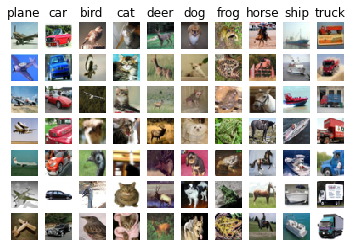

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Step - 5 (Flattening the images)

In the next cell we flatten each image into a single dimensional vector so that it is easy to process. You should be able to reason about the dimensions comfortable.

In [5]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


### Step - 6 (Apply all possible classification algorithms)

For each algo complete the following steps with appropriate plots, diagrams and code - 
1. Discuss the intuition behind each algorithm
2. Mention pros and cons
3. Discuss about Model parameters and Hyperparameters
4. Discuss about overfitting and underfitting with relavant plots and code (Hint: Use cross validation and plot hyperparameter vs accuracy score)
5. Discuss about train and test time/space complexities
6. Measure the performance of model using various metrics and write in detail about each metric

In [6]:
# defining blank list for the input of scores of models
model_accuracy=[]
model_precision=[]
model_recall=[]
model_f1_score=[]
model_roc_auc_score=[]
model_train_time=[]


In [7]:
# making a function to train the model and evaluate the model
def train_and_score (model,X_test,X_train,y_test,y_train, best_parameter=True, best_score=True):
  '''
  train the model and gives mse,rmse,r2,adj r2 score of the model
  can be used for any model where y is not transformed 
  '''

  #storing the start time of model training
  start=time.time()
  #training the model
  model.fit(X_train,y_train)
  #storing the time when the model ended trining 
  stop = time.time()
  #calculating the total time taken for model training 
  time_min=round((stop - start)/60,4)
  # printing the time taken to train the model
  print(f"Training time: {time_min}min")
  model_train_time.append(time_min)
  
  

  # finding the best parameters of the model if any 
  if best_parameter==True:
    # using try except method to avoid any error
    try:
      print("The best parameters found out to be :" ,model.best_params_)
    except:
      pass
  # finding best score of the model 
  if best_score==True:
    try:
      print(" \nwhere negative mean squared error is: ", model.best_score_,'\n')
    except:
      pass


  #predicting the values of y from x via model
  y_pred_test = model.predict(X_test)
  y_pred_train = model.predict(X_train)

  def score (actual,predicted,append=True):
    '''
    calcuating diffrent score matrix of the model
    '''
    # calculating f1_score score
    f1 = f1_score(actual,predicted,average='micro')

    
    # printing all the scores
    print("\tThe f1 is ", f1)

    # uploading all the score of the matrix in in the list 
    if append==True:
      model_f1_score.append(f1)
    else:
      pass
# printing the score by the help of coustom score function
  # for train set
  print('\t\t\t\tscore matrix for train')
  print('*'*80)
  score(y_train,y_pred_train,False)
  print('\n')
  # for test set
  print('\t\t\t\tscore matrix for test')
  print('*'*80)
  score(y_test,y_pred_test)


In [8]:
#importing all the important librarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, plot_precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

---
# Desision Tree
---

In [9]:
from sklearn.tree import DecisionTreeClassifier
# creating DecisionTree model
DecisionTree = DecisionTreeClassifier(max_depth=10,max_leaf_nodes=45,criterion='entropy')

# training and evaluating the DecisionTree
train_and_score(DecisionTree,X_test, X_train, y_test, y_train)

Training time: 0.4385min
				score matrix for train
********************************************************************************
	The f1 is  0.3346


				score matrix for test
********************************************************************************
	The f1 is  0.264


---
# Random forest
---

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
# creating Random Forest Regressor model
rfc=RandomForestClassifier(n_jobs=-1,verbose=0)

In [12]:
# training and evaluating the Random Forest Regressor
train_and_score(rfc,X_test, X_train, y_test, y_train,best_parameter=True)

Training time: 0.2383min
				score matrix for train
********************************************************************************
	The f1 is  1.0


				score matrix for test
********************************************************************************
	The f1 is  0.384


In [13]:
rfc.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(n_jobs=-1)>

## Implimenting grid search random forest
---

In [14]:
# creating RandomForestRegressor model
rfc=RandomForestClassifier()

In [15]:
rfc.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier()>

In [16]:
# finding the best parameters for knn_model by gridsearchcv
grid_values_rf = {'n_estimators': [100,125,150],'max_depth': [3,5,7],'criterion': ['entropy']}
rfc_grid = GridSearchCV(estimator=rfc,param_grid = grid_values_rf, scoring='recall',cv=5,verbose=5,n_jobs=-1)

In [17]:
# training and evaluating the Random Forest Regressor
train_and_score(rfc_grid,X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training time: 2.1972min
The best parameters found out to be : {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 100}
 
where negative mean squared error is:  nan 

				score matrix for train
********************************************************************************
	The f1 is  0.494


				score matrix for test
********************************************************************************
	The f1 is  0.2672


---
#XGboost
---

In [18]:
from xgboost import XGBClassifier

In [19]:
# creating XGBRegressor model
xgbc=XGBClassifier()

In [20]:
# training and evaluating the xgb_grid
train_and_score(xgbc,X_test, X_train, y_test, y_train)

Training time: 7.4892min
				score matrix for train
********************************************************************************
	The f1 is  0.8358


				score matrix for test
********************************************************************************
	The f1 is  0.398


In [21]:
xgbc.get_params

<bound method XGBModel.get_params of XGBClassifier(objective='multi:softprob')>

## implimenting grid search xgb
---

In [22]:
# finding the best parameters for XGBRegressor by gridsearchcv
xgbc_param={'n_estimators': [100,125,150],'max_depth': [7,10,15],'criterion': ['entropy']}
xgbc_grid=GridSearchCV(estimator=xgbc,param_grid=xgbc_param,cv=3,scoring='recall',verbose=5,n_jobs=-1)

In [ ]:
# training and evaluating the xgb_grid
train_and_score(xgbc_grid,X_test, X_train, y_test, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [ ]:
feature_importances_graph(xgbc_grid.best_estimator_,'Is_Defaulter')

---
# CatBoost
---

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
cb_model=CatBoostClassifier(verbose=0)

In [ ]:
# training and evaluating the PolynomialFeatures
train_and_score(cb_model,X_test, X_train, y_test, y_train)

In [ ]:
cb_model=CatBoostClassifier()

In [ ]:
# finding the best parameters for XGBRegressor by gridsearchcv
cat_para={'n_estimators': [100,125,150],'max_depth': [3,5,7]}
cat_grid=GridSearchCV(estimator=cb_model,param_grid=cat_para,cv=3,scoring='recall',verbose=3,n_jobs=-1)

In [ ]:
# training and evaluating the PolynomialFeatures
train_and_score(cat_grid,X_test, X_train, y_test, y_train)

---
# lightGBM
---

In [ ]:
import lightgbm as lgb

In [ ]:
lgbc=lgb.LGBMClassifier()

In [ ]:
# training and evaluating the lgbr_grid
train_and_score(lgbc, X_test, X_train, y_test, y_train)

In [ ]:
# finding the best parameters for XGBRegressor by gridsearchcv
lgbc_para={'n_estimators': [100,125,150],'max_depth': [3,5,7]}
lgbc_grid=GridSearchCV(estimator=lgbc,param_grid=lgbc_para,cv=3,scoring='recall',verbose=5,n_jobs=-1)

In [ ]:
# training and evaluating the lgbr_grid
train_and_score(lgbc_grid,X_test, X_train, y_test, y_train)

### Step - 7 (Compare all the models)

Conclude by following below mentioed steps -
1. Plot a table showing all the algorithms used and corresponding performance metrics
2. Is there any one algorithm that can be used on all the datasets? (Hint: Read about 'No Free Lunch' theorem)

---
# score matrix for all the models 
---

In [ ]:
#creating dictionary to store all the metrices 
dict={'f1':model_f1_score,'train_time':model_train_time}

In [ ]:
# list of all models
model_name=['Desision Tree','Random forest','Random forest Grid','XGboost','XGboost Grid','CATBoost','CATBoost Grid','lightGBM','lightGBM Grid']

In [ ]:
# converting dictionary to dataframe
matrix_df=pd.DataFrame.from_dict(dict,orient="index",columns=model_name)

In [ ]:
# taking the transpose of the dataframe to make it more visual appealing
matrix_df=matrix_df.transpose().reset_index().rename(columns={'index':'Models'})

In [ ]:
matrix_df

In [ ]:
matrix_df.train_time.sum()